<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/qml_course/variational_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install qiskit-aer
!pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw

In [2]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 12345

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (ad_hoc_data(training_size = 20, test_size=5, n = 2, gap = 0.3, one_hot = False))

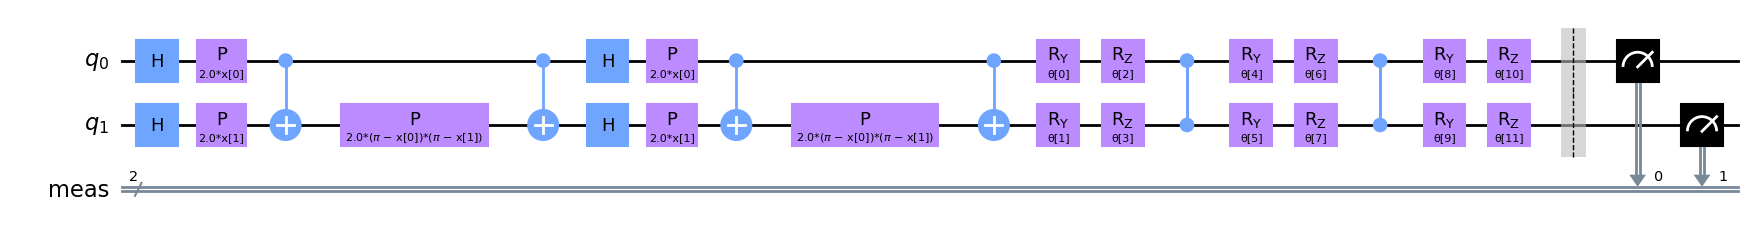

In [3]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps = 2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw("mpl")


In [4]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
      parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
      parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

In [5]:
def parity(bitstring):
  """Returns 1 if parity of `bitstring` is even, otherwise 0."""
  hamming_weight = sum(int(k) for k in list(bitstring))
  return (hamming_weight + 1) % 2

In [6]:
def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0:0, 1:0}
    for bitstring, counts in results.items():
      label = parity(bitstring)
      probabilities[label] += counts/shots
    return probabilities

In [7]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuits, backend)
    results = job.result()
    classification = [label_probability(results.get_counts(c)) for c in circuits]
    return classification

In [8]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

<ipython-input-9-0100112aaf4a>:12: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA


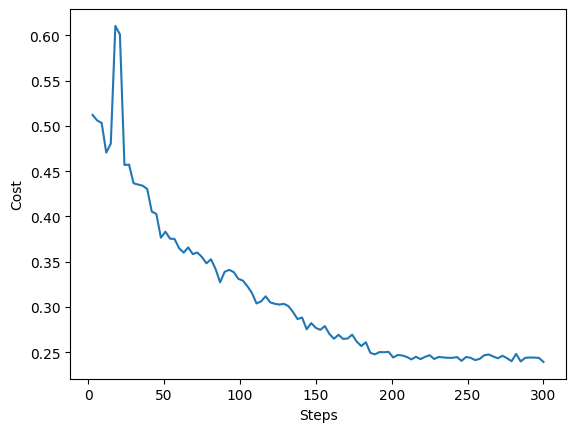

In [9]:
class OptimizerLog:

  def __init__(self):
    self.evaluations = []
    self.parameters = []
    self.costs = []
  def update(self, evaluation, parameter, cost, _stepsize, _accept):
    self.evaluations.append(evaluation)
    self.parameters.append(parameter)
    self.costs.append(cost)

from qiskit.algorithms.optimizers import SPSA

log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
      """Cost function of circuit parameters on training data.
      The optimizer will attempt to minimize this."""
      return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show();

In [10]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy

1.0

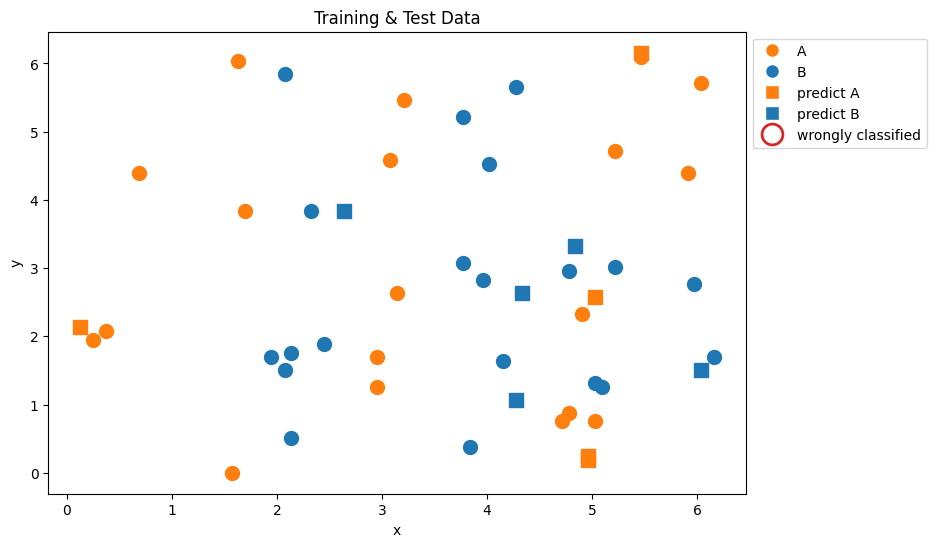

In [11]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, TRAIN_LABELS):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


### Qiskit Implementation

In [12]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()

In [13]:
#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(TRAIN_DATA, train_labels_oh)

<ipython-input-13-898500bcd79f>:9: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=FEATURE_MAP,


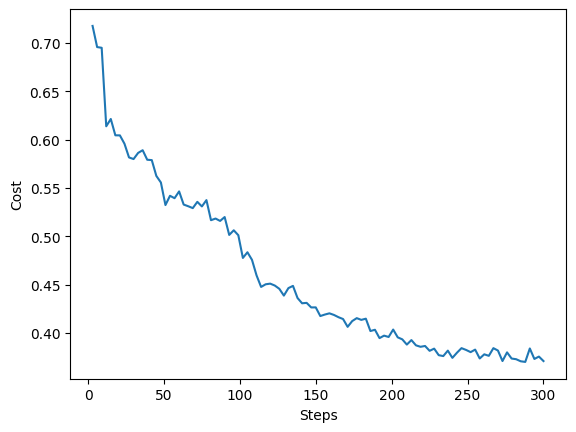

In [14]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [15]:
# score == accuracy
vqc.score(TEST_DATA, test_labels_oh)

1.0

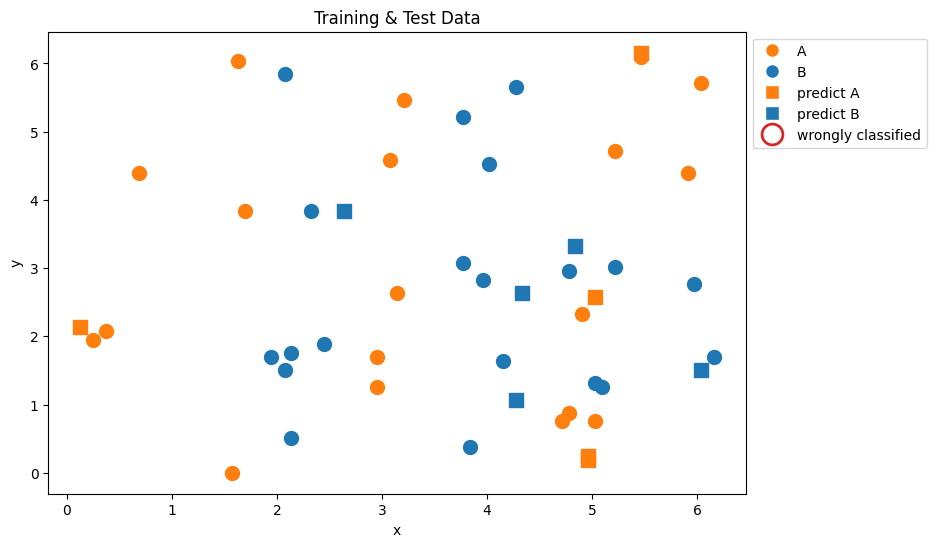

In [16]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, train_labels_oh):
    COLOR = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=COLOR)

for feature, label, pred in zip(TEST_DATA, test_labels_oh,
                                vqc.predict(TEST_DATA)):
    COLOR = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()